Identify a Supervised Machine Learning Problem (5 points)

Project Topic:
My project will be on building a supervised machine learning model for classification of pitch types. This project will primarily focus on pitcher Yoshinobu Yamamoto in the 2024-2025 season from the official MLB statcast website. Pitches have characteristics to them that help determine what type they are like velocity, spin rate, movement, etc. Statcast by MLB also has a column for pitch_type label already. Because of this it is a supervised learning project and our goal is going to be to predict pitch type categories like fastballs, splitters, curveballs & more. The goal is to develop our model so it can predict accurately the pitches thrown by Yamamoto based on those characteristics. This in the real world can help Front offices, players, and coaches with scouting and figuring out how to play against a pitcher. We will also hopefully find reasons why certain characteristics matter for different pitches. We are going to use a logistic Regression as our base model, then we are going to try out random forest classifers and do some XGBoost on it as well. 


Our data is coming from Baseball Savant that is a platform made by the MLB. Specifically, we pulled the data of Yoshinobu Yamamoto in the 2024-2025 season and its pitch-by-pitch statistics for the baseball season. There is data for 5,274 pitches(rows) and has 118 features (columns). This is a free and open resource that downloads to csv



Baseball Savant – Statcast Search
https://baseballsavant.mlb.com/statcast_search

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [134]:
df = pd.read_csv("yamamoto_2024_2025_statcast.csv")

print(df.shape)
print(df.head().T.head(10))

print("Data types:")
print(df.dtypes.head(20))

(5274, 118)
                                 0                    1                    2  \
pitch_type                      FF                   FS                   FS   
game_date               2024-03-30           2024-03-30           2024-03-30   
release_speed                 95.3                 89.6                 89.5   
release_pos_x                 -1.4                -1.37                -1.45   
release_pos_z                 5.42                 5.42                 5.32   
player_name    Yamamoto, Yoshinobu  Yamamoto, Yoshinobu  Yamamoto, Yoshinobu   
batter                      543063               543063               543063   
pitcher                     808967               808967               808967   
events                   field_out                  NaN                  NaN   
description          hit_into_play        called_strike         blocked_ball   

                                 3                    4  
pitch_type                      FS               

Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

First we are going to find the missing values in our data and see whether we need to delete them or not. Were going to plot the top 10 columns that have the most missing columns percentage against the whole amount of columns. 

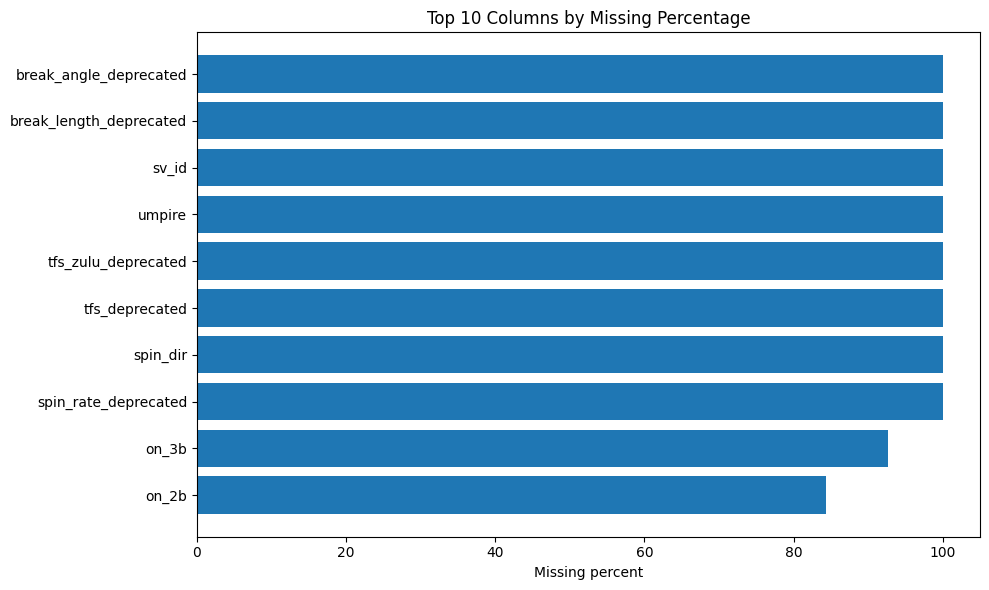

In [135]:
missing_counts = df.isna().sum()
missing_pct = (missing_counts / len(df)) * 100
missing = (pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct}).sort_values("missing_pct", ascending=False))

plt.figure(figsize=(10, 6))
top_missing = missing.head(10)
plt.barh(top_missing.index, top_missing["missing_pct"])
plt.xlabel("Missing percent")
plt.title("Top 10 Columns by Missing Percentage")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Clearly, there is a lot of missing data, some at the 100% level, so let's get rid of any column that doesn't have at least 40% of its data. 

Let's also look at the columns we are going to delete to make sure there isn't any column that we are going to need for pitching data for our model 

In [136]:

# columns that have have have more that 40% of their data missing
missing_cols = missing[missing["missing_pct"] > 40].index.tolist()
# drop the cols
cols_to_drop = [col for col in missing_cols + id_like_cols if col in df.columns]
print(cols_to_drop)
df_clean = df.drop(columns=cols_to_drop)
# Drop the sweeper pitch, only used 4 times, so misidentified or does not use regularly enough
df_clean = df_clean[df_clean["pitch_type"] != "ST"]
print(df_clean.shape)


['break_angle_deprecated', 'break_length_deprecated', 'sv_id', 'umpire', 'tfs_zulu_deprecated', 'tfs_deprecated', 'spin_dir', 'spin_rate_deprecated', 'on_3b', 'on_2b', 'estimated_slg_using_speedangle', 'estimated_ba_using_speedangle', 'launch_speed_angle', 'bb_type', 'hc_x', 'hc_y', 'hit_location', 'estimated_woba_using_speedangle', 'woba_denom', 'events', 'woba_value', 'babip_value', 'iso_value', 'on_1b', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'hyper_speed', 'intercept_ball_minus_batter_pos_y_inches', 'intercept_ball_minus_batter_pos_x_inches', 'bat_speed', 'swing_length', 'attack_angle', 'attack_direction', 'swing_path_tilt', 'game_pk', 'game_year', 'home_team', 'away_team', 'game_date', 'player_name', 'pitcher', 'batter']
(5270, 75)


This brought down our columns by a lot 118 to 75, and it looks like none of the columns we deleted are what we needed for our model

ALso, got rid of the sweeper pitch, it looks like Yamamoto either doesn't throw this type of pitch that often (4 times in a year) or these were misclassified. 

After we got rid of the sweeper lets look at pitch distribution to make sure there isn't more pitches like the sweeper(ST) that need to be removed

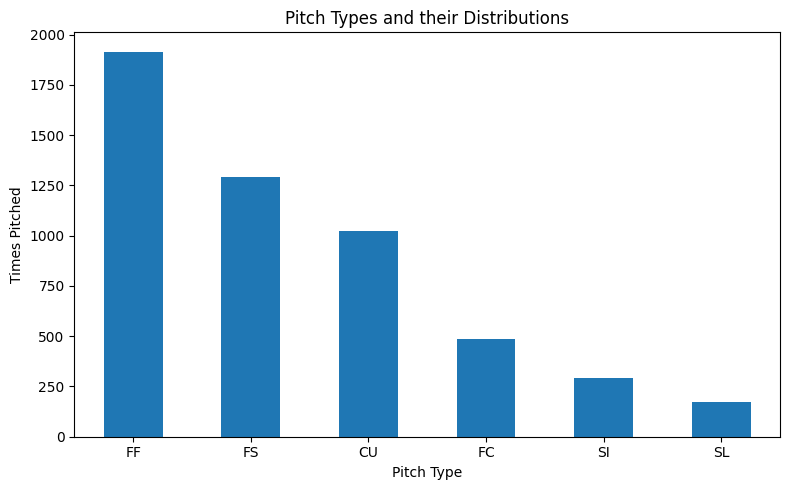

In [137]:
plt.figure(figsize=(8, 5))
df_clean["pitch_type"].value_counts().plot(kind="bar")
plt.ylabel("Times Pitched")
plt.title("Pitch Types and their Distributions")
plt.xlabel("Pitch Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Even though we got rid of the empty columns, we still need to deal with NaNs in our data, so we are going to get rid of them by putting the median in for the numeric cols (like int, float) and the mode for non numeric cols (like strings). Our model is going to benefit a lot from not having NaN values in it and hopefully give us better results because of it. 

FF - Four Seam Fastball
FS - Splitter
CU - Change Up
FC - Cutter
SI - Sinker
SL - Slider

In [138]:
print("number of nans: ",  df_clean.isna().sum().sum())

# Get rid of the Nans in columns that are numeric & non numberic
# if a NaN is in a numberic column were going to put in the median instead
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_clean[col].isna().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
print("number of nans: ",  df_clean.isna().sum().sum())

# if a NaN is any other column,fill with it with the mode
non_numeric_cols = df_clean.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    if df_clean[col].isna().sum() > 0:
        mode_val = df_clean[col].mode().iloc[0]
        df_clean[col].fillna(mode_val, inplace=True)
print("number of nans: ",  df_clean.isna().sum().sum())
df_clean.shape

number of nans:  4137
number of nans:  430
number of nans:  0


/var/folders/z2/_qq1slsj7d3ghtds37x6xwd40000gn/T/ipykernel_56797/4105166253.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
/var/folders/z2/_qq1slsj7d3ghtds37x6xwd40000gn/T/ipykernel_56797/4105166253.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

(5270, 75)

In [139]:

print(df_clean.shape)
# df_clean


(5270, 75)


For our cleaning we got rid of empty columns (more than 40% empty), we took care of NaN values for numberic and non numberic columns, we got rid of the sweeper pitch, and we also looked at pitch distribution. 

This should give us cleaned data that is going to much better to work with and not cause errors in our model. This data was clearly given to give the most statistics avaliable so while I respect all the columns that were included, it looks like it was a bit overkill. 

EDA

We already made a Distribution of types of pitches earlier on when we deleted the sweeper type from our data. So now let's create a correlation matrix of our numeric columns only (non numberic can't be on the correlation matrix) to see what features in our data correlate strongly or weakly. This will help us move forward in how we choose our models. 

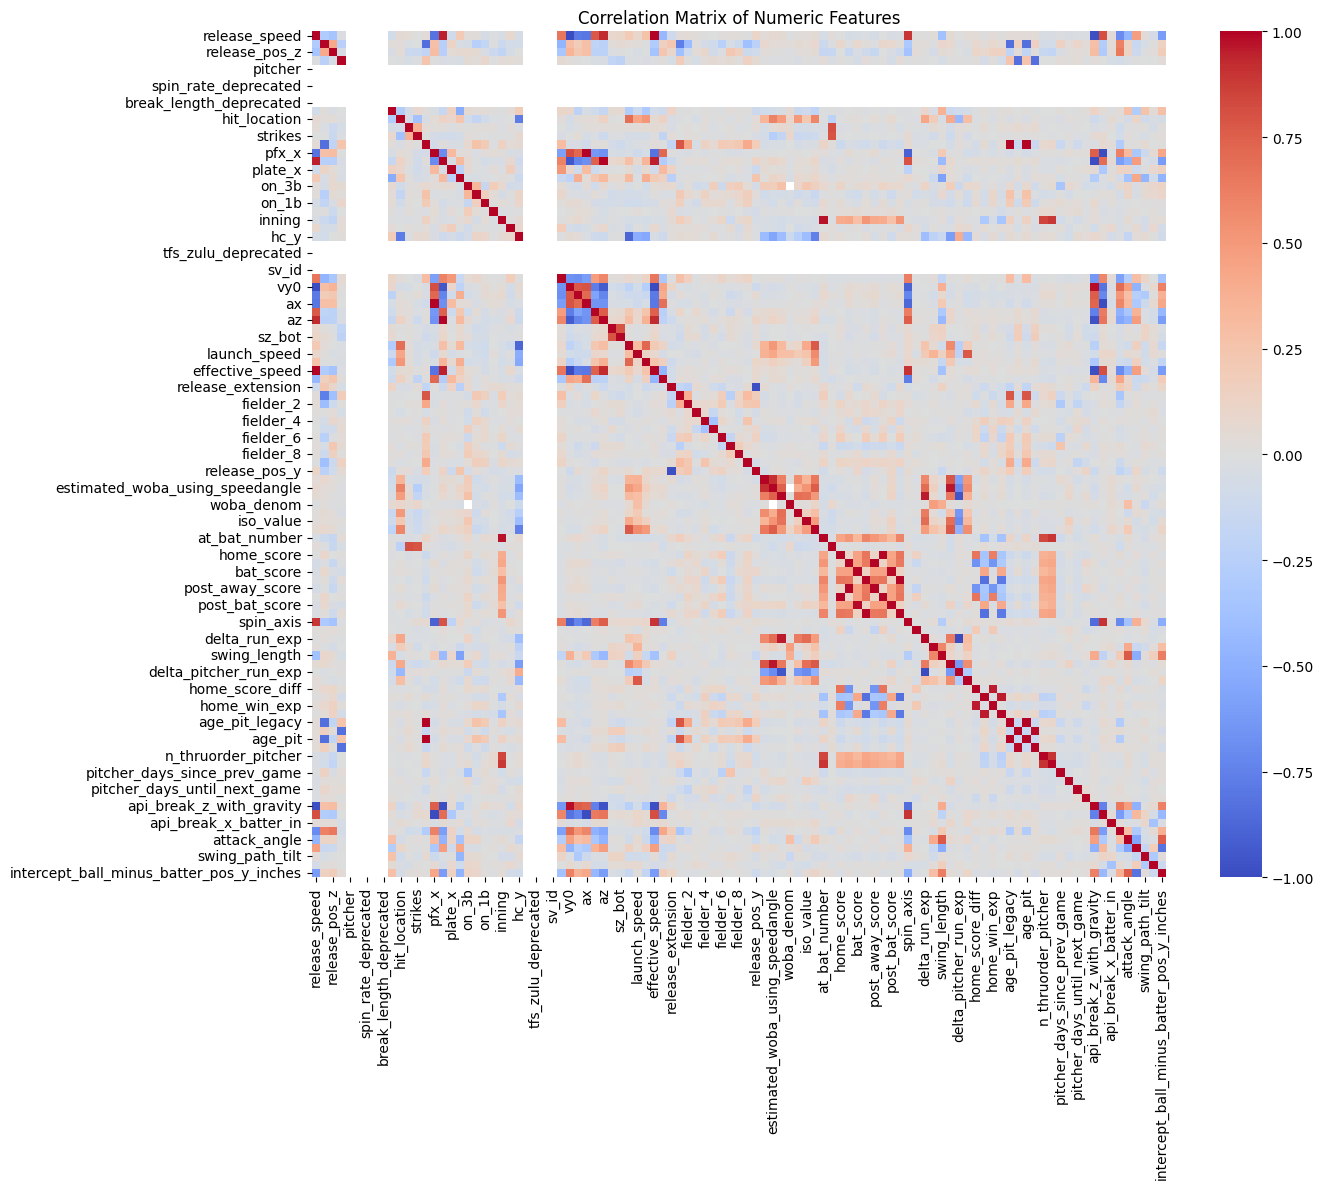

In [140]:
# getting only the numberic columns
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
# plotting
plt.figure(figsize=(14,12))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()


Looking at our correlation matrix we can see that there are many features are are correlated positively or negatively, with this we can also see that there are nonlinear relationship that are important and I believe using random forest model is going to help out with that. 



Now let's look at Pitch movement horizonal and vertical. Baseball pitches are known to have movement to them, this is going to be a plot of types of pitches of Yamamoto by their horizontal and vertical movement.

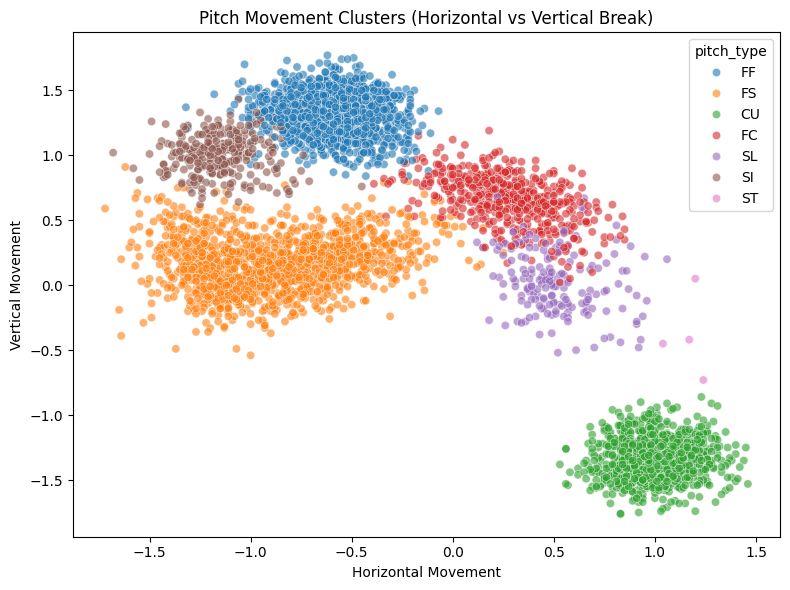

In [141]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="pfx_x",
    y="pfx_z",
    hue="pitch_type",
    alpha=0.6,
    palette="tab10"
)
plt.title("Pitch Movement Clusters (Horizontal vs Vertical Break)")
plt.xlabel("Horizontal Movement")
plt.ylabel("Vertical Movement")
plt.tight_layout()
plt.show()

This gives very good information that there are type of pitch clusters that are separated a good distance. This gives us indication that pitch types should be predictable using features. 

On a interesting note, Yamamoto's most famous pitch is the splitter (FS) has the biggest cluster with the highest horizontal movement. 

FF - Four Seam Fastball
FS - Splitter
CU - Change Up
FC - Cutter
SI - Sinker
SL - Slider

In conclusion to our EDA, we can see that there are features that are strongly and weakly correlated via our correlation matrix, which will be good for our models to predict pitches and the horizonal and vertical movement show us that pitches by type can have strong clustering given features we have. So our EDA was successful in helping us determine that our models will be good for logictic regression and random forest. 

Perform Analysis Using Supervised Machine Learning Models of your Choice, Present Discussion and Conclusions

I am going to filter out more columns based on the correlation matrix we made, and choose only the ones I believe are going to help with our model 

Let's start with a basic Logistic Regression model, this will give up a linear decision boundary and answer the question if pitch types are linearly separable in our project. 

In [143]:
# Let filter for only the features we need and split the data
features = [
    "release_speed",
    "release_pos_x",
    "release_pos_z",
    "pfx_x",
    "pfx_z",
    "plate_x",
    "plate_z",
    "balls",
    "strikes",
    "arm_angle"
]

X = df_clean[features]
y = df_clean["pitch_type"]

# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [157]:
# Linear Regression Model just like we did in a lab
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(
    multi_class="multinomial",
    max_iter=1000,
    class_weight="balanced"
)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))
print(accuracy_score(y_test, y_pred_lr))

              precision    recall  f1-score   support

          CU       1.00      1.00      1.00       204
          FC       0.95      0.98      0.96        98
          FF       0.99      0.94      0.97       400
          FS       0.96      0.97      0.97       259
          SI       0.80      0.98      0.88        58
          SL       1.00      1.00      1.00        35

    accuracy                           0.97      1054
   macro avg       0.95      0.98      0.96      1054
weighted avg       0.97      0.97      0.97      1054

0.9686907020872866


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/brennanhan/

Our multinomial Linear Regression actually got a very high accuracy score of 96.86%. Even though linear regression can only do linear decision boundaries it was about to get a solid score, however its most likely not going to beat random tree or XGB in its accuracy as they can do non linear interations between features, and I believe that is going to help their accuracy scores. 

In [158]:
random_forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight="balanced",
    random_state=42
)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

          CU       1.00      1.00      1.00       204
          FC       0.99      0.99      0.99        98
          FF       0.99      0.99      0.99       400
          FS       1.00      1.00      1.00       259
          SI       0.97      0.97      0.97        58
          SL       1.00      1.00      1.00        35

    accuracy                           0.99      1054
   macro avg       0.99      0.99      0.99      1054
weighted avg       0.99      0.99      0.99      1054

0.9943074003795066


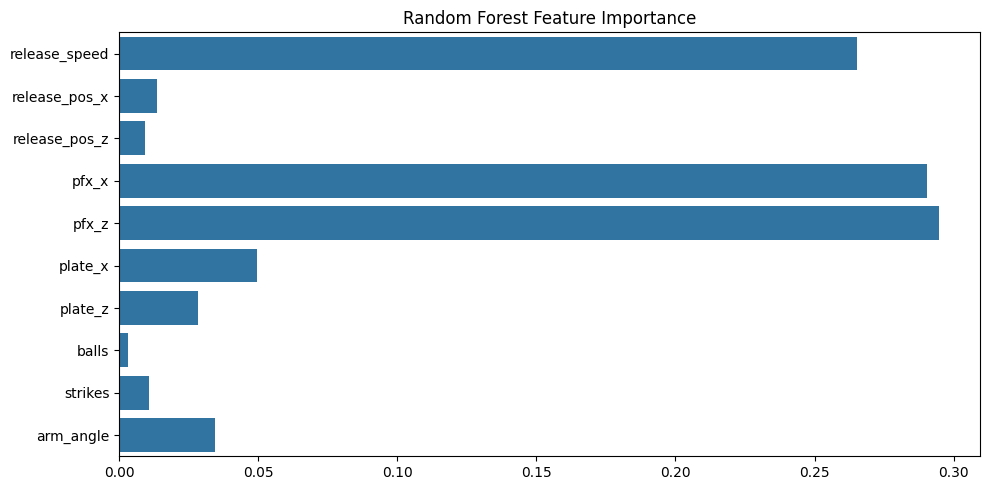

In [146]:
plt.figure(figsize=(10,5))
sns.barplot(x=rf.feature_importances_, y=features)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

Random Forest Classifier got a 99.43% accuracy score which is very good and is better than logistic regression. Its able to do non linear boundaries allows for pitches to be more distinguished in their clusters and that is the reason I think for its high score. 

I also plotted the most important features to our random forest classification model, and we can see that release speed, horizontal and vertical movement seem to be the best predictors of the pitch type. 

In [159]:
# XGB 
# XGB is picky and does like our pitch type so we have to encode them to ints
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_clean["pitch_type"])
# we have to recreate our split train and test because of this
xgb_X_train, xgb_X_test, xgb_y_train, xgb_y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
# run xgbclassifer 
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(label_encoder.classes_),
    eval_metric="mlogloss",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method = "hist"
)
xgb.fit(xgb_X_train, xgb_y_train)

# we have to now decode the pitch type back 
y_pred_encoded = xgb.predict(xgb_X_test)
y_test_labels = label_encoder.inverse_transform(xgb_y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

y_pred_xgb = xgb.predict(xgb_X_test)
print(classification_report(y_test_labels, y_pred_labels, labels=label_encoder.classes_))
print(accuracy_score(xgb_y_test, y_pred_xgb))

              precision    recall  f1-score   support

          CU       1.00      1.00      1.00       204
          FC       0.97      0.98      0.97        98
          FF       1.00      0.99      0.99       400
          FS       1.00      0.99      0.99       259
          SI       0.97      0.98      0.97        58
          SL       0.97      1.00      0.99        35

    accuracy                           0.99      1054
   macro avg       0.98      0.99      0.99      1054
weighted avg       0.99      0.99      0.99      1054

0.9924098671726755


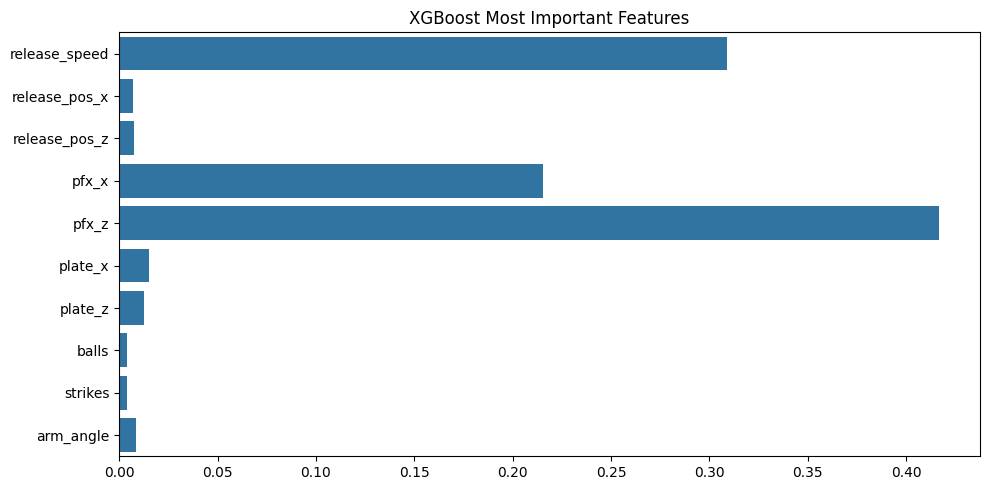

In [148]:
plt.figure(figsize=(10,5))
sns.barplot(x=xgb.feature_importances_, y=features)

plt.title("XGBoost Most Important Features")
plt.tight_layout()
plt.show()

XGBoost actually surprised me in its accuracy score, when I thought it would be the best model it lost out to random forest. Perhaps our pitching type data is more suited for random forest ,but it is not a big difference at all. XGB does a lot of regularization and small interactions and maybe this is why it performed slightly worse than random forest. 

The most important features of XGB were the same release speed and horizontal and vertical movement in pitch determination. XGB favored horizontal movement less than release speed than random forest and this is potentially a reason why the accuracy was slightly lower. 

In [149]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(xgb_y_test, y_pred_xgb)

print("Linear Regression Accuracy: ", accuracy_lr,"Random Forest Accuracy: ",accuracy_rf,"XGB Accuracy: ",accuracy_xgb)

Linear Regression Accuracy:  0.9686907020872866 Random Forest Accuracy:  0.9943074003795066 XGB Accuracy:  0.9924098671726755


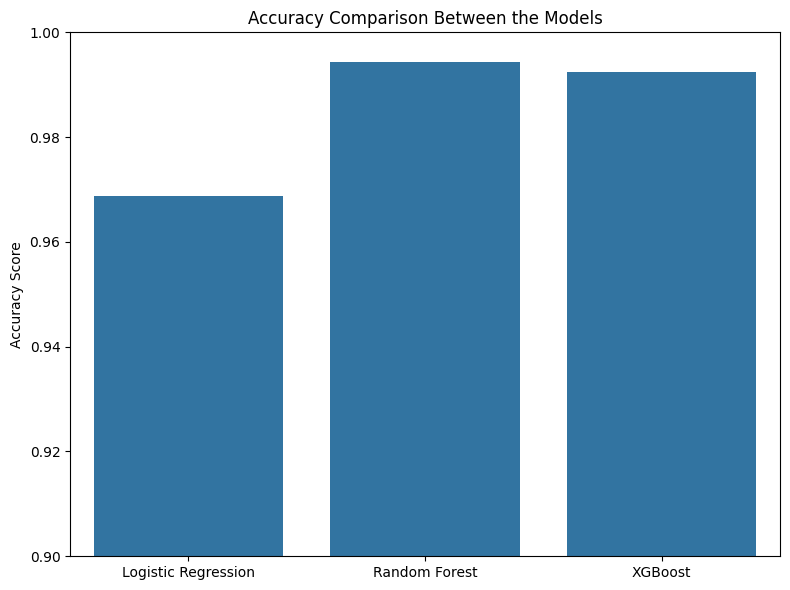

In [156]:
accuracy_scores = {
    "Logistic Regression": accuracy_lr,
    "Random Forest": accuracy_rf,
    "XGBoost": accuracy_xgb
}

plt.figure(figsize=(8,6))
sns.barplot(x=list(accuracy_scores.keys()), 
            y=list(accuracy_scores.values()))

plt.title("Accuracy Comparison Between the Models")
plt.ylabel("Accuracy Score")
plt.ylim(0.9, 1.0)
plt.tight_layout()
plt.show()

Linear Regression Accuracy:  0.9686907020872866 
Random Forest Accuracy:  0.9943074003795066 
XGB Accuracy:  0.9924098671726755

In our models Random Forest was the best followed by XGB a slight margin and then Logistic Regression. This makes sense as those top two are non linear and Logistic Regression is linear. However, the accuracy rating accross the three were very high and gave us insights on which features are the most important when it comes to categorizing pitches namely pitching speed and vertical and horizontal movement. 



Conclusion:
In conclusion, my three models all performed very well but Random Tree was the best in terms of accuracy. Things that went well are that supervised learning models and predicting pitching types do very well together. It seems like some of our features like horizontal and vertical movement help create good clusters and helped with the performance of all models. Also, the data being able to get was very beneficial as the Statcast website was very easy to use. Because random forest ran the best, I am to believe that tree based models are the best models for pitch type predictions

However, some difficulties I faced were that the data had a lot of empty values and NaNs and cleaning up the data was quite the chore in the beginning. Also, the rare pitch ST only had 4 examples in the data so I had to filter it. Also, XGBoost is difficult to get up and running on Mac Silicon and provided a challenge to get my enviroment working with this model. XGB also didn't like some of my labeling for pitch types and I had to encode some labels in order for it to work, so it was harder to impliment than the other two models. 

Things to improve would be adding things like pitch count (amount of pitches thrown) as this might affect movement and speed and it could cause our model to struggle. Another thing to look at would be the strike ball count and how that affects what pitch is thrown as there is a whole mental game behind baseball pitching as well. I would also like to model other players, as Yoshinobu Yamamoto is a great pitcher who won the World Series MVP, it would be interesting to train and test a model on a different player, or maybe a player who doesn't have as much movement in their pitches. 